### **Schritt 1: Importieren der Abhängigkeiten**

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### **Schritt 2: Laden der Daten**

In [2]:
# die Pfade zu den Dateien zu laden
movies_path = "https://raw.githubusercontent.com/andresmorenoviteri/workshops/refs/heads/main/movies.csv"
ratings_path = "https://raw.githubusercontent.com/andresmorenoviteri/workshops/refs/heads/main/ratings.csv"

In [3]:
movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

### **Schritt 3: Datenexploration** 

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
n_ratings = len(ratings_df)
n_movies = ratings_df["movieId"].nunique()
n_users = ratings_df['userId'].nunique()

print(f"number of ratings: {n_ratings}")
print(f"movies rated: {n_movies}")
print(f"users: {n_users}")
print(f"average number of ratings per movie: {round(n_ratings/n_movies, 2)}")
print(f"average number of ratings per user: {round(n_ratings/n_users, 2)}") # very high number, not realistic, usually only a couple of ratings

number of ratings: 100836
movies rated: 9724
users: 610
average number of ratings per movie: 10.37
average number of ratings per user: 165.3


### Verteilung der Filmbewertungen

<Axes: xlabel='rating', ylabel='count'>

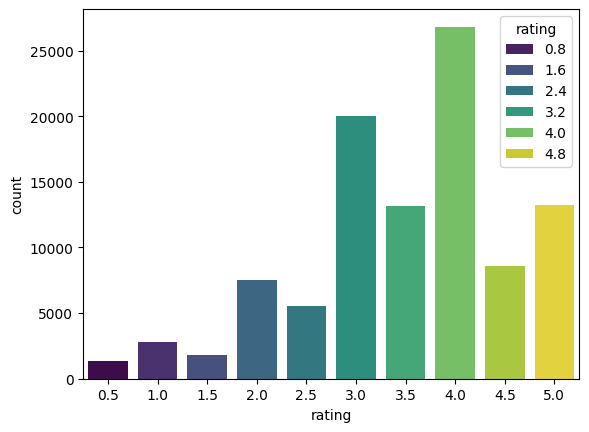

In [8]:
# Sind die Bewertungen gleichmäßig verteilt oder in irgendeiner Weise verzerrt?
sns.countplot(x='rating', hue='rating', data=ratings_df, palette='viridis')

In [9]:
print(f"mean global rating: {round(ratings_df['rating'].mean(), 2)}")

mean_rating = ratings_df.groupby('userId')['rating'].mean()
print(f"mean rating per user: {round(mean_rating.mean(), 2)}")

mean global rating: 3.5
mean rating per user: 3.66


In [10]:
ratings_df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


### Welche Filme werden am häufigsten bewertet?

In [11]:
ratings_df['movieId'].value_counts()

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: count, Length: 9724, dtype: int64

In [12]:
movie_ratings_df = ratings_df.merge(movies_df, how='inner', on='movieId')
movie_ratings_df['title'].value_counts()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Sex, Drugs & Taxation (2013)          1
Extraordinary Tales (2015)            1
Tomorrow (2015)                       1
Embrace of the Serpent (2016)         1
31 (2016)                             1
Name: count, Length: 9719, dtype: int64

In [13]:
# prüfen, ob in den Datensätzen Leerstellen vorhanden sind
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


Forrest Gump, Shawshank redemption und Pulp Fiction sind die meistbewerteten Filme

### Welches sind die am schlechtesten und am besten bewerteten Filme?

In [14]:
movie_ratings_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [15]:
movie_stats = movie_ratings_df.groupby('title')['rating'].agg(['count', 'mean']).reset_index()
movie_stats.head()

,title,count,mean
0,'71 (2014),1,4.0
1,'Hellboy': The Seeds of Creation (2004),1,4.0
2,'Round Midnight (1986),2,3.5
3,'Salem's Lot (2004),1,5.0
4,'Til There Was You (1997),2,4.0


In [16]:
lowest_rated = movie_stats.loc[movie_stats['mean'].idxmin()]['title']
print(f'lowest rated movie: {lowest_rated}')

lowest rated movie: 3 Ninjas Knuckle Up (1995)


In [17]:
highest_rated = movie_stats.loc[movie_stats['mean'].idxmax()]['title']
print(f'highest rated movie: {highest_rated}')

highest rated movie: 'Salem's Lot (2004)


In [18]:
# Anzahl der Bewertungen für Salem's Lot überprüfen 
len(movie_stats[movie_stats['title'] == "'Salem's Lot (2004)"])

1

eine einzige Bewertung reicht nicht aus, um einen hoch bewerteten Film zu erhalten, verwenden Sie den Bayes'schen Durchschnitt, um eine bessere Vorhersage zu erhalten

**Bayesianischer Durchschnitt**

Der Bayesianische Durchschnitt ist eine Methode zur Schätzung des Mittelwerts einer Grundgesamtheit unter Verwendung externer Informationen, insbesondere einer bereits bestehenden Überzeugung, die in die Berechnung einfließt.

Der Bayesianische Durchschnitt ist definiert als:

$x_{i} =  \frac{C \times m + \Sigma{\text{ratings}}}{C+N}$
 
- $C$ wird auf der Grundlage der Größe des Datensatzes gewählt, in unserem Fall ist es die durchschnittliche Anzahl der Bewertungen für jeden Film.
- $m$ ist der vorherige Mittelwert, in unserem Fall also die durchschnittliche Bewertung eines Films.
- $N$ ist die Gesamtzahl der Bewertungen für den Film $i$.

In [19]:
c = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f'average number of ratings for a given movie: {round(c, 2)}')
print(f'average rating for a given movie: {round(m, 2)}')

# create new column with Bayesian averages
bayesian_average_list = []
for idx, row in movie_stats.iterrows():
    x = ((c*m)+(row['count']*row['mean']))/((c)+row['count'])
    bayesian_average_list.append(x)

average number of ratings for a given movie: 10.38
average rating for a given movie: 3.26


In [20]:
movie_stats['bayesian_average'] = bayesian_average_list
movie_stats.head()

,title,count,mean,bayesian_average
0,'71 (2014),1,4.0,3.327233
1,'Hellboy': The Seeds of Creation (2004),1,4.0,3.327233
2,'Round Midnight (1986),2,3.5,3.300790
3,'Salem's Lot (2004),1,5.0,3.415144
4,'Til There Was You (1997),2,4.0,3.381597


In [21]:
movie_stats[movie_stats['title'].str.contains("Salem's Lot")]

,title,count,mean,bayesian_average
3,'Salem's Lot (2004),1,5.0,3.415144


sehen wir, dass „Salem's Lot“ nicht mehr der am besten bewertete Film ist

In [22]:
bayesian_min = movie_stats.loc[movie_stats['bayesian_average'].idxmin()]['title']
bayesian_min

'Speed 2: Cruise Control (1997)'

In [23]:
bayesian_max = movie_stats.loc[movie_stats['bayesian_average'].idxmax()]['title']
bayesian_max

'Shawshank Redemption, The (1994)'

In [24]:
movie_stats.sort_values(by='bayesian_average', ascending=False)

,title,count,mean,bayesian_average
7593,"Shawshank Redemption, The (1994)",317,4.429022,4.392049
3499,"Godfather, The (1972)",192,4.289062,4.236428
3011,Fight Club (1999),218,4.272936,4.227026
8001,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.192624
9119,"Usual Suspects, The (1995)",204,4.237745,4.190541
...,...,...,...,...
8187,Superman IV: The Quest for Peace (1987),16,1.687500,2.307011
466,Anaconda (1997),27,1.925926,2.296921
3508,Godzilla (1998),33,1.954545,2.267376
866,Battlefield Earth (2000),19,1.657895,2.224593


Die bestbewerteten Filme sind Shawshank Redemption, Godfather und Fight Club

Die am schlechtesten bewerteten Filme sind Speed 2, Battlefield Earth und Godzilla

### Ein Blick auf Filmgenres

In [25]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [26]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : x.split('|'))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**Filmgenres zählen**

In [27]:
from collections import Counter

genres_list = movies_df['genres'].explode()
genre_counts = Counter(genres_list)
genre_counts

Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [28]:
print(f"the 5 most common genres are: {genre_counts.most_common(5)}")

the 5 most common genres are: [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


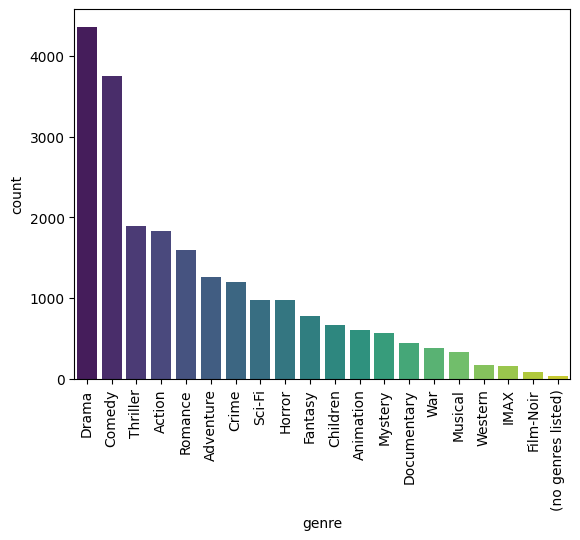

In [29]:
genre_counts_df = pd.DataFrame([genre_counts]).T.reset_index()
genre_counts_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', hue='genre', data=genre_counts_df.sort_values(by='count', ascending=False), legend=False, palette='viridis')
plt.xticks(rotation=90)
plt.show()

### **Schritt 4: Vorverarbeitung der Daten**

Wir werden die Technik der kollaborativen Filterung anwenden, um Empfehlungen für die Benutzer zu erstellen.
Die Grundlage für diese Technik ist, dass ähnliche Nutzer einen ähnlichen Filmgeschmack haben.

Wir beginnen damit, unsere Daten in eine „Nutzwertmatrix“ umzuwandeln, d. h. eine Matrix aus Nutzern und Objekten. Die Zeilen werden repräsentieren die Nutzer, während die Spalten die Filme darstellen.

In [102]:
movie_ratings_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [31]:
movie_stats['count'][movie_stats['title'] == 'Toy Story (1995)']

8871    215
Name: count, dtype: int64

In [32]:
from scipy.sparse import csr_matrix

def create_matrix(df):

    rows = df['userId'].nunique()
    columns = df['movieId'].nunique()

    userMapper = dict(zip(np.unique(df['userId']), list(range(rows))))
    movieMapper = dict(zip(np.unique(df['movieId']), list(range(columns))))

    invUserMapper = dict(zip(list(range(rows)), np.unique(df['userId'])))
    invMovieMapper = dict(zip(list(range(columns)), np.unique(df['movieId'])))

    # create the user-item interaction matrix
    userMovieMatrix = pd.pivot_table(df, values='rating', index='userId', columns='movieId').fillna(0)
    sparseMatrix= csr_matrix(userMovieMatrix)

    # convert matrx to sparse matrix
    return sparseMatrix, userMapper, movieMapper, invUserMapper, invMovieMapper 

sparse_matrix, user_mapper, movie_mapper, inv_user_mapper, inv_movie_mapper = create_matrix(movie_ratings_df)

In [33]:
sparse_matrix.nnz

100836

### Sparsamkeit berechnen
Die Sparsamkeit wird berechnet, indem die Anzahl der gespeicherten (nicht leeren) Felder durch die Gesamtzahl der Felder geteilt wird. Die Anzahl der gespeicherten Werte in unserer Matrix entspricht der Anzahl der Bewertungen in unserem Datensatz.

In [34]:
n_total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
num_ratings = sparse_matrix.nnz #csr_matrix.nnz counts the stored values in the sparse matrix. The rest of the cells are empty
sparsity = num_ratings / n_total
print(f"Matrix sparsity: {round(sparsity*100, 2)}%")

Matrix sparsity: 1.7%


Das **Kaltstartproblem** tritt auf, wenn es neue Nutzer und Filme gibt, die noch keine Bewertungen haben.
 
In unserem Movielens-Datensatz haben alle Nutzer und Filme mindestens eine Bewertung, aber im Allgemeinen ist es wichtig, zu prüfen, ob Nutzer und Filme wenige oder keine Interventionen haben


hier wird überprüft, ob alle Zellen im Datensatz nicht leer sind

In [35]:
n_ratings_per_user = sparse_matrix.getnnz(axis=1)
len(n_ratings_per_user)

610

In [36]:
print(f"The most active user rated {n_ratings_per_user.max()} movies")
print(f"The least active user rated {n_ratings_per_user.min()} movies")

The most active user rated 2698 movies
The least active user rated 20 movies


In [37]:
n_ratings_per_movie = sparse_matrix.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [38]:
print(f"The most rated movie has {n_ratings_per_movie.max()} ratings")
print(f"The least rated movie has {n_ratings_per_movie.min()} ratings")

The most rated movie has 329 ratings
The least rated movie has 1 ratings


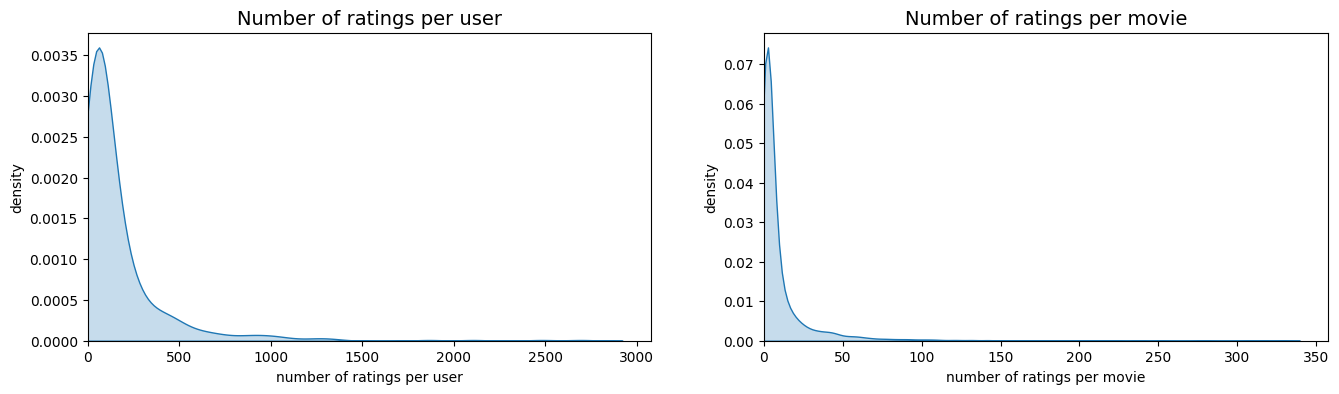

In [39]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of ratings per user", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1, 2, 2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of ratings per movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### **Schritt 5: Item-Empfehlungen mit *K-Nearest-Neighbor***

Wir werden die k Filme finden, die die ähnlichsten Vektoren für das Nutzerengagement für einen Film i haben.


In [59]:
from sklearn.neighbors import NearestNeighbors

def find_recommended_movies(movieId, sparseMatrix, movieMapper, invMovieMapper, k, metric='cosine'):
    # transpose matrix to get movie recommendations from matrix
    sparseMatrix = sparseMatrix.T
    recommendationIds = []
    movieIdx = movieMapper[movieId]
    movieVec = sparseMatrix[movieIdx]
    if isinstance(movieVec, (np.ndarray)):
        movieVec = movieVec.reshape(1, -1)
    # use k+1 since knn outputs include the movieId of interest
    knn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute')
    knn.fit(sparseMatrix)
    recommendations = knn.kneighbors(movieVec, return_distance=False)
    for i in range(0, k):
        n = recommendations.item(i)
        recommendationIds.append(invMovieMapper[n])
    recommendationIds.pop(0)
    return recommendationIds

In [105]:
movie_mapper[33794]

5901

interaktive Grafik

In [126]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def interactive_visualization(sparseMatrix, movieMapper, invMovieMapper, k, metric='cosine'):
    # Transpose sparse matrix
    sparseMatrix = sparseMatrix.T

    # Normalize before dimensionality reduction
    scaler = StandardScaler()
    scaledSparseMatrix = scaler.fit_transform(sparseMatrix.toarray())  

    # Apply t-SNE for better visualization
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    reducedMatrix = tsne.fit_transform(scaledSparseMatrix)

    # Create a DataFrame for visualization
    df = pd.DataFrame(reducedMatrix, columns=['PCA1', 'PCA2'])
    df['movieId'] = [invMovieMapper[i] for i in range(sparseMatrix.shape[0])]

    # Map movieId to titles efficiently
    movie_id_to_title = movie_ratings_df.set_index('movieId')['title'].to_dict()
    df['title'] = df['movieId'].map(movie_id_to_title)

    # Fit KNN for recommendations
    knn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute')
    knn.fit(sparseMatrix)

    def get_recommendations(movieId):
        movieIdx = movieMapper[movieId]
        movieVec = sparseMatrix[movieIdx]
        movieVec = movieVec.reshape(1, -1) if isinstance(movieVec, np.ndarray) else movieVec
        recommendations = knn.kneighbors(movieVec, return_distance=False)[0][1:]  # Exclude the movie itself
        return [invMovieMapper[n] for n in recommendations]

    # Generate recommendations
    df['recommendations'] = df['movieId'].apply(lambda x: [movie_id_to_title.get(int(i), "Unknown") for i in get_recommendations(x)])

    # Assign unique color values
    df['color'] = range(len(df))

    # Create an interactive scatter plot
    fig = px.scatter(
        df,
        x='PCA1',
        y='PCA2',
        hover_data=['title', 'recommendations'],
        title="Movie Clusters with Recommendations",
        template='plotly_dark',
        color='color',
        opacity=0.6
    )

    # Improve marker visibility
    fig.update_traces(marker=dict(size=4, opacity=0.7))
    fig.update_layout(clickmode='event+select')

    # Show the plot
    fig.show()

# Call the function with appropriate parameters
interactive_visualization(sparse_matrix, movie_mapper, inv_movie_mapper, 5)

**find_recommended_movies()** liefert eine Liste von **movieIds**, die dem gewünschten Film am ähnlichsten sind.

Wir erstellen ein Wörterbuch, das die **movieId** dem **title** des Films zuordnet.

In [86]:
movie_titles = find_recommended_movies(33794, sparse_matrix, movie_mapper, inv_movie_mapper, 10) 
movie_titles

5901


[58559, 6539, 44191, 32587, 7153, 6874, 7438, 8961, 6365]

In [88]:
# aus den gefundenen Indizes, müssen wir diese in die dazu passende movieId umwandeln. 
print(f"for the movie {movie_ratings_df['title'].loc[movie_ratings_df['movieId'] == 33794].unique().item()}, the recommendations are:")
for id in movie_titles:
    print(movie_ratings_df['title'].loc[movie_ratings_df['movieId'] == id].unique().item())

for the movie Batman Begins (2005), the recommendations are:
Dark Knight, The (2008)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
V for Vendetta (2006)
Sin City (2005)
Lord of the Rings: The Return of the King, The (2003)
Kill Bill: Vol. 1 (2003)
Kill Bill: Vol. 2 (2004)
Incredibles, The (2004)
Matrix Reloaded, The (2003)


für den Film Toy Story scheinen die Empfehlungen alle Filme aus den 90er Jahren zu sein, was logisch erscheint

wir könnten auch andere Abstandsmetriken neben *Kosinus* ausprobieren, wie *Manhattan* oder *Euklidisch*.

*Kosinus* ist eine gute Metrik, wenn wir nicht die Größe der Vektoren für den Abstand in Betracht ziehen wollen, sondern eher die Richtung des Vektors

Bei der Verwendung von *Manhattan*- oder *Euklidischen*-Distanzen ist es wichtig, die Daten vor ihrer Anwendung zu normalisieren, wenn die verschiedenen Parameter unserer Daten unterschiedliche Bereiche aufweisen.

die beste Praxis in diesem Schritt zur Optimierung der Hyperparameter ist die Durchführung von Gittersuchen, insbesondere die zufällige Gittersuche

In [ ]:
movie_titles = find_recommended_movies(1, sparse_matrix, movie_mapper, inv_movie_mapper, 10, metric='euclidean') 
movie_titles

In [ ]:
# aus den gefundenen Indizes müssen wir diese in die dazu passende movieId umwandeln 
print(f"for the movie {movie_ratings_df['title'].loc[movie_ratings_df['movieId'] == 1].unique().item()}, the recommendations are:")
for id in movie_titles:
    print(movie_ratings_df['title'].loc[movie_ratings_df['movieId'] == id].unique().item())

Bei Verwendung des euklidischen Abstands ergeben sich einige verschiedene Filme

### **Schritt 6: Behandlung des Kaltstartproblems**

Die kollaborative Filterung stützt sich ausschließlich auf die Interaktionen zwischen Nutzern und Objekten innerhalb der Nutzwertmatrix. Das Problem bei diesem Ansatz besteht darin, dass ein neuer Benutzer oder ein neues Element aus der Nutzenmatrix ausgeschlossen wird, sobald es einen solchen gibt. Dies ist als **Kaltstartproblem** bekannt. Die inhaltsbasierte Filterung ist eine Möglichkeit, dieses Problem zu umgehen, da sie sich auf die Erstellung von Empfehlungen auf der Grundlage von Benutzer- und Artikelmerkmalen konzentriert.

Wir beginnen mit der Umwandlung einer *Genre*-Spalte in binäre Merkmale. Jedes Genre hat seine eigene Spalte und wird mit 1en und 0en gefüllt.

In [ ]:
movies_df = pd.read_csv(movies_path)
movies_df.head()

In [ ]:
movie_genres = movies_df['genres'].str.get_dummies(sep='|')
movie_genres.head()

In [ ]:
movie_genres.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Die *cosine_similarity* ermittelt einen Wert zwischen 0 und 1, der angibt, wie ähnlich jede Zeile der einen Matrix den anderen Zeilen der zweiten Matrix ist.

1 bedeutet identisch und 0 ist völlig unterschiedlich. 

Da wir ursprünglich 9742 Filme haben, ist es richtig, dass die Form dieser Matrix wie folgt aussehen würde $(n_{\text{movies}}, n_{\text{movies}})$

#### Erstellen einer Filmfindungsfunktion

Wenn wir Filmempfehlungen ähnlich wie Jumanji erhalten möchten, müssen wir den genauen Titel kennen, wie er in unserem Datensatz erscheint. Jumanji ist zum Beispiel als „Jumanji (1995)“ aufgeführt. Wenn wir ihn falsch schreiben oder das Erscheinungsjahr vergessen, erkennt der Empfehlungsgeber den Film nicht.

Um es den Nutzern leichter zu machen, können wir das Python-Paket fuzzywuzzy verwenden. Es hilft dabei, den Titel zu finden, der am ehesten mit einer vom Benutzer eingegebenen Zeichenkette übereinstimmt. Wir werden eine Funktion, movie_finder(), erstellen, die fuzzywuzzy's String-Matching verwendet, um die beste Übereinstimmung für den Eingabetitel vorzuschlagen.

In [ ]:
from fuzzywuzzy import process

def movie_finder(title):
    all_movies = movies_df['title'].tolist()
    closest_match = process.extractOne(title, all_movies)
    return closest_match[0]

test mit jumanji

In [ ]:
title = movie_finder('jumaidi')
title

um eine Empfehlung zu erhalten, erstellen wir einen Film-Mapper für den Index in der Matrix

In [ ]:
movie_idx = dict(zip(movies_df['title'], list(movies_df.index)))
idx = movie_idx[title]
print(f"movie index for Jumanji: {idx}")

Wir erstellen eine Funktion, um die Empfehlungen für einen bestimmten Film zu erhalten

In [64]:
def find_similar_movies(movieTitle, n_recommendations=10):
    title = movie_finder(movieTitle)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x : x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendations+1]
    similar_movies = [i[0] for i in sim_scores]
    print(f"because you watched {title}")
    print(movies_df['title'].iloc[similar_movies])

In [ ]:
find_similar_movies('Toy story', 3)

### **Schritt 7: Matrixfaktorisierung zur Dimensionalitätsreduktion**

Die Matrixfaktorisierung (MF) ist ein Verfahren der linearen Algebra, mit dem latente Merkmale entdeckt werden können, die den Interaktionen zwischen Nutzern und Filmen zugrunde liegen. Diese latenten Merkmale ermöglichen eine kompaktere Darstellung der Vorlieben der Nutzer und der Objektbeschreibungen. MF ist besonders nützlich für sehr spärliche Daten und kann die Qualität von Empfehlungen verbessern. Der Algorithmus funktioniert durch Faktorisierung der ursprünglichen Benutzer-Element-Matrix in zwei Faktormatrizen:

- Benutzer-Faktor-Matrix (n_Nutzer, k)
- Artikel-Faktor-Matrix (k, n_Einzelteile)

Wir reduzieren die Dimensionen unserer ursprünglichen Matrix auf „Geschmacks“-Dimensionen. Wir können die genaue Bedeutung der einzelnen latenten Merkmale *k* nicht interpretieren. Wir können uns jedoch mögliche Bedeutungen für sie vorstellen, z. B. könnte ein Merkmal für Nutzer stehen, die Comedy-Action-Filme aus den frühen 2000er Jahren mögen, während ein anderes für Bollywood-Filme aus den 90er Jahren stehen könnte.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(sparse_matrix.T)
Q.shape

In [ ]:
movie_id = 1
recommended_movies = find_recommended_movies(movieId=movie_id, sparseMatrix=Q.T, movieMapper=movie_mapper, invMovieMapper=inv_movie_mapper, metric='cosine', k=10)

print(f"for the movie {movie_ratings_df['title'].loc[movie_ratings_df['movieId'] == movie_id].unique().item()}, the recommendations are:")
for id in recommended_movies:
    print(movie_ratings_df['title'].loc[movie_ratings_df['movieId'] == id].unique().item())

Die Ergebnisse sind ähnlich wie bei einem KNN-Modell, es scheinen durchweg Filme aus den 90er Jahren zu sein, einschließlich einiger früherer Kinderfilme